<a href="https://colab.research.google.com/github/SidouPrince/annonces_similaires/blob/main/Test_Yanport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* crée avec google colab
* j'ai importé le data set dans google colab '/content/nom_dataset' 


#Import libraries

In [1]:
# Execute this before starting

!pip install unidecode
import spacy.cli
spacy.cli.download("fr_core_news_md")

     |████████████████████████████████| 245kB 3.9MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_md')


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.interpolate import make_interp_spline
from sklearn.decomposition import PCA

import unidecode
import re # Regular Expression (Regex) in Python
from nltk.stem.snowball import FrenchStemmer
import spacy
import fr_core_news_md
from spacy.lang.fr.stop_words import STOP_WORDS
from spacy.tokens import Doc
nlp = spacy.load('fr_core_news_md')

# Load & Cleaning

In [7]:
df = pd.read_csv('/content/Dataset - Ads _ Levallois-Perret - 2019-08 - export-ads-levallois-perret-2019-08-27.csv')
df.head(5)

,ID,URL,CRAWL_SOURCE,PROPERTY_TYPE,NEW_BUILD,DESCRIPTION,IMAGES,SURFACE,LAND_SURFACE,BALCONY_SURFACE,TERRACE_SURFACE,ROOM_COUNT,BEDROOM_COUNT,BATHROOM_COUNT,LUNCHROOM_COUNT,TOILET_COUNT,FURNISHED,FIREPLACE,AIR_CONDITIONING,GARDEN,SWIMMING_POOL,BALCONY,TERRACE,CELLAR,PARKING,PARKING_COUNT,HEATING_TYPES,HEATING_MODE,FLOOR,FLOOR_COUNT,CONSTRUCTION_YEAR,ELEVATOR,CARETAKER,ENERGY_CONSUMPTION,GREENHOUSE_GAS_CONSUMPTION,MARKETING_TYPE,PRICE,PRICE_M2,PRICE_EVENTS,RENTAL_EXPENSES,RENTAL_EXPENSES_INCLUDED,DEPOSIT,FEES,FEES_INCLUDED,EXCLUSIVE_MANDATE,AGENCIES_UNWANTED,OCCUPIED,DEALER_NAME,DEALER_TYPE,CITY_ID,CITY,ZIP_CODE,DEPT_CODE,PUBLICATION_START_DATE,PUBLICATION_END_DATE,LAST_CRAWL_DATE,LAST_PRICE_DECREASE_DATE
0,22c05930-0eb5-11e7-b53d-bbead8ba43fe,http://www.avendrealouer.fr/location/levallois...,A_VENDRE_A_LOUER,APARTMENT,False,"Au rez de chaussée d'un bel immeuble récent,ap...","[""https://cf-medias.avendrealouer.fr/image/_87...",72.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1.0,[],COLLECTIVE,NaN,NaN,NaN,True,NaN,NaN,NaN,RENT,1979.0,27.49,"[{""price"":1979,""date"":""2017-03-22""}]",276.0,True,NaN,NaN,NaN,False,NaN,NaN,Lamirand Et Associes,AGENCY,54178039,Levallois-Perret,92300.0,92,2017-03-22T04:07:56.095,NaN,2017-04-21T18:52:35.733,NaN
1,8d092fa0-bb99-11e8-a7c9-852783b5a69d,https://www.bienici.com/annonce/ag440414-16547...,BIEN_ICI,APARTMENT,False,Je vous propose un appartement dans la rue Col...,"[""http://photos.ubiflow.net/440414/165474561/p...",48.0,NaN,NaN,NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,False,NaN,[],INDIVIDUAL,1.0,6.0,NaN,True,False,NaN,NaN,SALE,429000.0,8937.50,"[{""price"":452000.0,""date"":""2018-09-18""},{""pric...",NaN,NaN,NaN,NaN,False,False,NaN,False,Proprietes Privees,MANDATARY,54178039,Levallois-Perret,92300.0,92,2018-09-18T11:04:44.461,NaN,2019-06-06T10:08:10.89,2018-09-25
2,44b6a5c0-3466-11e9-8213-25cc7d9bf5fc,https://www.bellesdemeures.com/annonces/vente/...,BELLES_DEMEURES,APARTMENT,False,"Dans un cadre arboré, calme et fleuri, un pent...","[""https://v.seloger.com/s/width/965/visuels/0/...",267.0,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SALE,4970000.0,18614.23,"[{""price"":4970000.0,""date"":""2019-02-19""}]",NaN,NaN,NaN,NaN,NaN,False,NaN,False,Propriétés Parisiennes,AGENCY,54178039,Levallois-Perret,92300.0,92,2019-02-19T16:49:03.547,NaN,2019-06-13T08:22:14.314,NaN
3,e9e07ed0-812f-11e8-82aa-61eacebe4584,https://www.seloger.com/annonces/locations/bur...,SE_LOGER,PREMISES,False,"""Le meilleur coworking flexible de la ville, 5...","[""https://pix.yanport.com/ads/e9e07ed0-812f-11...",50.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RENT,89.0,1.78,"[{""price"":89.0,""date"":""2018-07-06""}]",NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,Iwg,AGENCY,54178039,Levallois-Perret,92300.0,92,2018-07-06T15:18:59.805,NaN,2019-06-18T10:40:07.405,NaN
4,872302b0-5a21-11e9-950c-510fefc1ed35,https://www.bellesdemeures.com/annonces/vente/...,BELLES_DEMEURES,HOUSE,False,Levallois - Parc de la Planchette A toute prox...,"[""https://v.seloger.com/s/width/966/visuels/0/...",330.0,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SALE,2790000.0,8454.55,"[{""price"":3150000.0,""date"":""2019-04-08""},{""pri...",NaN,NaN,NaN,NaN,NaN,False,NaN,False,Daniel Feau Neuilly,AGENCY,54178039,Levallois-Perret,92300.0,92,2019-04-08T17:12:20.123,NaN,2019-06-14T15:02:18.155,2019-06-14


In [44]:
num_rows = df.shape[0]
num_columns = df.shape[1]
#df.describe()
print("Nombre de lignes: ", num_rows)
print("Nombre de colonnes: ", num_columns)

Nombre de lignes:  2164
Nombre de colonnes:  57


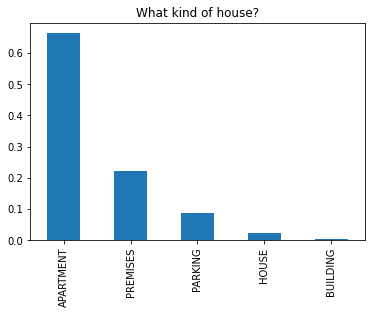

In [45]:
property_vals = df['PROPERTY_TYPE'].value_counts()

(property_vals/num_rows).plot(kind="bar");
plt.title("What kind of house?");

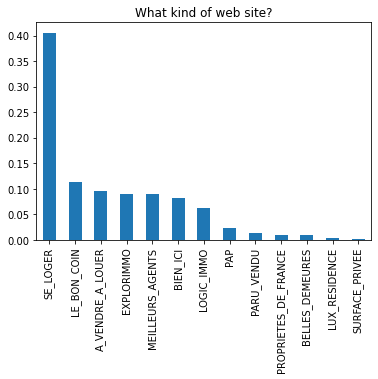

In [46]:
crawl_source_vals = df['CRAWL_SOURCE'].value_counts()

(crawl_source_vals/num_rows).plot(kind="bar");
plt.title("What kind of web site?");

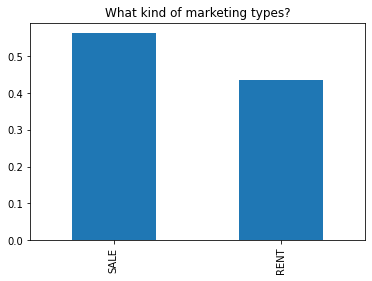

In [47]:
marketing_type_vals = df['MARKETING_TYPE'].value_counts()

(marketing_type_vals/num_rows).plot(kind="bar");
plt.title("What kind of marketing types?");

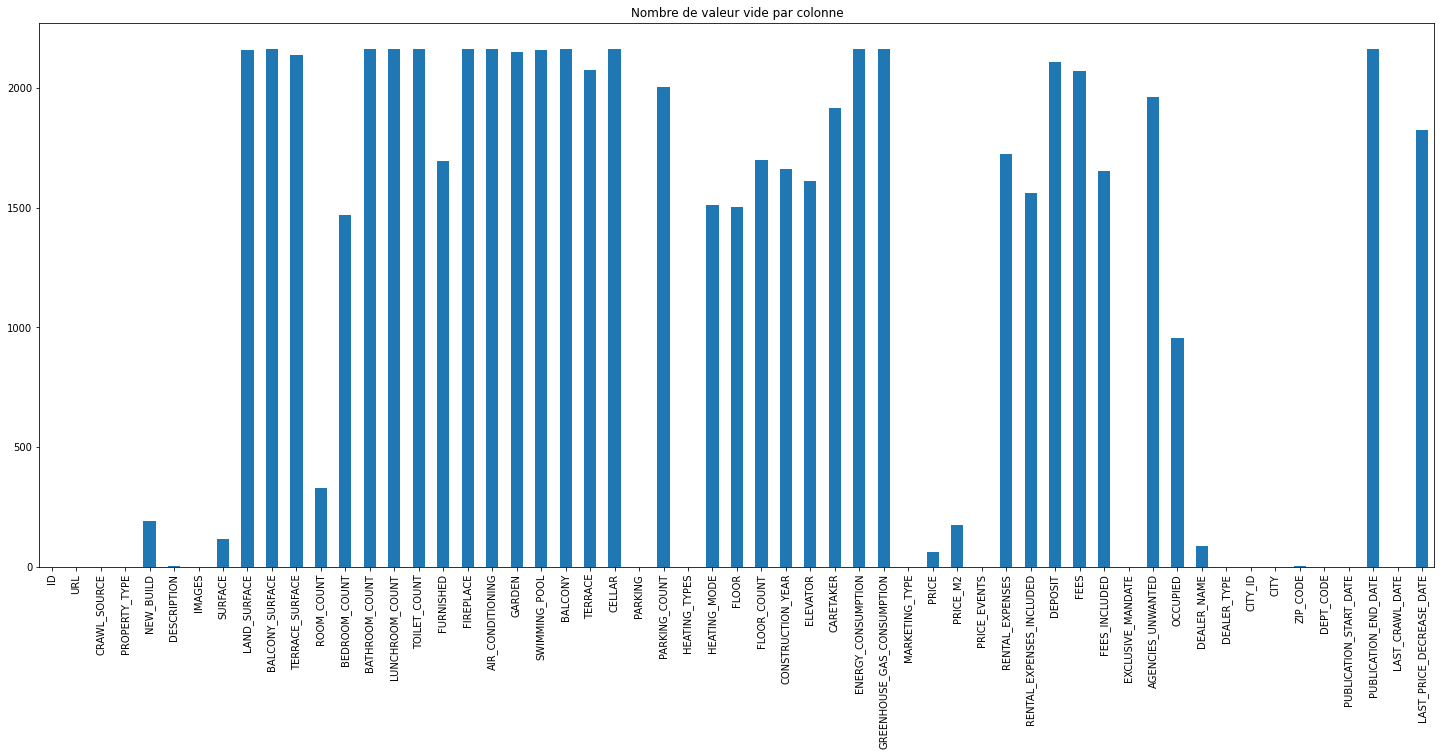

In [48]:
#Nombre de valeur null dans chaque colonne
np.sum(df.isnull()).plot(kind="bar", figsize=(25, 10), title="Nombre de valeur vide par colonne")

In [49]:
#Columns that have more then 60% of missing values
more_then_60 = []
for col in df.columns:
  if np.sum(df[col].isnull()) / num_rows >= 0.60:
    more_then_60.append(col)
print(more_then_60)

['LAND_SURFACE', 'BALCONY_SURFACE', 'TERRACE_SURFACE', 'BEDROOM_COUNT', 'BATHROOM_COUNT', 'LUNCHROOM_COUNT', 'TOILET_COUNT', 'FURNISHED', 'FIREPLACE', 'AIR_CONDITIONING', 'GARDEN', 'SWIMMING_POOL', 'BALCONY', 'TERRACE', 'CELLAR', 'PARKING_COUNT', 'HEATING_MODE', 'FLOOR', 'FLOOR_COUNT', 'CONSTRUCTION_YEAR', 'ELEVATOR', 'CARETAKER', 'ENERGY_CONSUMPTION', 'GREENHOUSE_GAS_CONSUMPTION', 'RENTAL_EXPENSES', 'RENTAL_EXPENSES_INCLUDED', 'DEPOSIT', 'FEES', 'FEES_INCLUDED', 'AGENCIES_UNWANTED', 'PUBLICATION_END_DATE', 'LAST_PRICE_DECREASE_DATE']


In [50]:
#Delete columns that have more then 60% of missing values
df_clean = df.drop(more_then_60, axis=1)
print(df_clean.shape)
df_clean.head(1)

(2164, 25)


,ID,URL,CRAWL_SOURCE,PROPERTY_TYPE,NEW_BUILD,DESCRIPTION,IMAGES,SURFACE,ROOM_COUNT,PARKING,HEATING_TYPES,MARKETING_TYPE,PRICE,PRICE_M2,PRICE_EVENTS,EXCLUSIVE_MANDATE,OCCUPIED,DEALER_NAME,DEALER_TYPE,CITY_ID,CITY,ZIP_CODE,DEPT_CODE,PUBLICATION_START_DATE,LAST_CRAWL_DATE
0,22c05930-0eb5-11e7-b53d-bbead8ba43fe,http://www.avendrealouer.fr/location/levallois...,A_VENDRE_A_LOUER,APARTMENT,False,"Au rez de chaussée d'un bel immeuble récent,ap...","[""https://cf-medias.avendrealouer.fr/image/_87...",72.0,3.0,True,[],RENT,1979.0,27.49,"[{""price"":1979,""date"":""2017-03-22""}]",False,NaN,Lamirand Et Associes,AGENCY,54178039,Levallois-Perret,92300.0,92,2017-03-22T04:07:56.095,2017-04-21T18:52:35.733


In [51]:
#We dont need those columns 
city_id_valus = df_clean['CITY_ID'].value_counts()
city_valus = df_clean['CITY'].value_counts()
dept_code = df_clean['DEPT_CODE'].value_counts()
print(city_id_valus)
print(city_valus)
print(dept_code)



54178039    2164
Name: CITY_ID, dtype: int64
Levallois-Perret    2164
Name: CITY, dtype: int64
92    2164
Name: DEPT_CODE, dtype: int64


Aprés avoir supprimer les valeurs null la colonne **marketing_type** a seulement un seul type.
On peut la supprimé

In [52]:
df_clean.dropna(axis=0, inplace=True)
df_clean['MARKETING_TYPE'].value_counts()

SALE    1045
Name: MARKETING_TYPE, dtype: int64

**Deux anonnces sont similaires si elles ont** :
 * Deux descriptions similaires
 * Property_Type, Surfacce, Room_count et Price similaires

**Creation de deux datasets**
* df_clean_description
* df_clean_num


In [53]:
needed_columns = ['PROPERTY_TYPE', 'SURFACE','PRICE', 'ROOM_COUNT']
not_needed_columns = [col for col in df_clean.columns if col not in needed_columns]

df_clean_description_serie = df_clean['DESCRIPTION']
desc = {'DESCRIPTION': df_clean_description_serie}

df_clean_description = pd.DataFrame(desc)
df_clean_num = df_clean.drop(not_needed_columns, axis=1)

print(np.sum(df_clean_num.isnull()))
print(np.sum(df_clean_description.isnull()))
print(df_clean_num.shape)
print(df_clean_description.shape)

PROPERTY_TYPE    0
SURFACE          0
ROOM_COUNT       0
PRICE            0
dtype: int64
DESCRIPTION    0
dtype: int64
(1045, 4)
(1045, 1)


In [54]:
df_clean_description.head()

,DESCRIPTION
1,Je vous propose un appartement dans la rue Col...
2,"Dans un cadre arboré, calme et fleuri, un pent..."
4,Levallois - Parc de la Planchette A toute prox...
5,LEVALLOIS - FRONT DE SEINE - 5-6 PIECES Appart...
9,A VENDRE APPARTEMENT DE 2 PIÈCES MAIRIE DE LEV...


In [55]:
df_clean_num.head(10)

,PROPERTY_TYPE,SURFACE,ROOM_COUNT,PRICE
1,APARTMENT,48.00,2.0,429000.0
2,APARTMENT,267.00,6.0,4970000.0
4,HOUSE,330.00,8.0,2790000.0
5,APARTMENT,142.76,5.0,1420000.0
9,APARTMENT,57.00,2.0,570000.0
12,APARTMENT,69.00,3.0,669000.0
13,APARTMENT,66.27,4.0,560000.0
14,APARTMENT,30.00,1.0,325001.0
24,APARTMENT,39.00,2.0,345000.0
25,APARTMENT,48.00,2.0,449000.0


#Feature engineering


In [56]:
def tokenize(text):
  """
  INPUT: String Description of house
  OUTPUT: A list of tokens without special characters
  """
  token_pattern = re.compile(r"(?:[a-zA-ZÀ-ÖØ-ö0-9])+'?")
  tokens = re.findall(token_pattern, text)
  tokens = [t for t in tokens]
  return tokens

In [57]:
df_clean_description['tokens'] = df_clean_description['DESCRIPTION'].apply(tokenize)

In [58]:
df_clean_description.head()

,DESCRIPTION,tokens
1,Je vous propose un appartement dans la rue Col...,"[Je, vous, propose, un, appartement, dans, la,..."
2,"Dans un cadre arboré, calme et fleuri, un pent...","[Dans, un, cadre, arboré, calme, et, fleuri, u..."
4,Levallois - Parc de la Planchette A toute prox...,"[Levallois, Parc, de, la, Planchette, A, toute..."
5,LEVALLOIS - FRONT DE SEINE - 5-6 PIECES Appart...,"[LEVALLOIS, FRONT, DE, SEINE, 5, 6, PIECES, Ap..."
9,A VENDRE APPARTEMENT DE 2 PIÈCES MAIRIE DE LEV...,"[A, VENDRE, APPARTEMENT, DE, 2, PIÈCES, MAIRIE..."


In [59]:
def remove_accents(token):
  """
  INPUT:  A token
  OUTPUT: The same token without accents
  """
  return unidecode.unidecode(token)

In [60]:
#Application de la fonction remove_accents
df_clean_description['tokens'] = df_clean_description['tokens'].apply(lambda x : [remove_accents(t) for t in x] )

In [61]:
# Stemming : on enlève les "terminaisons" des mots

def stemmatisation(token): 
  """
  INPUT:  A token 
  OUTPUT: The stem of the token
  """
  stemmer = FrenchStemmer()
  return stemmer.stem(token)

In [62]:
#Application de la fonction stemmatisation
df_clean_description['tokens'] = df_clean_description['tokens'].apply(lambda x: [stemmatisation(t) for t in x])

In [63]:
df_clean_description.head()

,DESCRIPTION,tokens
1,Je vous propose un appartement dans la rue Col...,"[je, vous, propos, un, appart, dan, la, ru, co..."
2,"Dans un cadre arboré, calme et fleuri, un pent...","[dan, un, cadr, arbor, calm, et, fleur, un, pe..."
4,Levallois - Parc de la Planchette A toute prox...,"[levallois, parc, de, la, planchet, a, tout, p..."
5,LEVALLOIS - FRONT DE SEINE - 5-6 PIECES Appart...,"[levallois, front, de, sein, 5, 6, piec, appar..."
9,A VENDRE APPARTEMENT DE 2 PIÈCES MAIRIE DE LEV...,"[a, vendr, appart, de, 2, piec, mair, de, leva..."


In [64]:
def del_stop_words(tokens):
  """
  INPUT:  A list of tokens [je, vous, propos, un, appart] 
  OUTPUT: The same list without STOP_WORDS 
  """
  for t in tokens:
    if t in STOP_WORDS:
      tokens.remove(t)
  return tokens

In [65]:
#Application de la fonction del_stop_words
df_clean_description['tokens'] = df_clean_description['tokens'].apply(lambda x: del_stop_words(x) )


In [66]:
df_clean_description.head(10)

,DESCRIPTION,tokens
1,Je vous propose un appartement dans la rue Col...,"[vous, propos, appart, dan, ru, collang, dan, ..."
2,"Dans un cadre arboré, calme et fleuri, un pent...","[dan, cadr, arbor, calm, fleur, penthous, 267,..."
4,Levallois - Parc de la Planchette A toute prox...,"[levallois, parc, planchet, tout, proximit, pa..."
5,LEVALLOIS - FRONT DE SEINE - 5-6 PIECES Appart...,"[levallois, front, sein, 5, 6, piec, appart, f..."
9,A VENDRE APPARTEMENT DE 2 PIÈCES MAIRIE DE LEV...,"[vendr, appart, 2, piec, mair, levallois, vend..."
12,LEVALLOIS -3 pièces 69m2\n\nPlace Georges Pomp...,"[levallois, 3, piec, 69m2, plac, georg, pompid..."
13,LEVALLOIS - MAIRIE - 4 PIECES Appartement 4 pi...,"[levallois, mair, 4, piec, appart, 4, piec, 2,..."
14,LEVALLOIS - STUDIO VENDU LOUE - 325 000 EUROS ...,"[levallois, studio, vendu, lou, 325, 000, euro..."
24,Appartements neufs grand standing du 2 au 3 pi...,"[appart, grand, standing, 2, 3, piec, part, 34..."
25,Dans une copropriété de grand standing de 2012...,"[dan, copropriet, grand, standing, 2012, bel, ..."


**TF-IDF (Term Frequency - Inverse Document Frequency)**:

Cette méthode cherche à réduire les poids des mots qui apparaissent dans de nombreux documents du corpus et qui portent donc moins d'information que les mots plus rares.

In [68]:
vectorizer = TfidfVectorizer(max_features=5000,
                             max_df=0.8,
                             min_df=5,
                             tokenizer=lambda x: x,
                             lowercase=False)

In [69]:
tf_idf_matrix = vectorizer.fit_transform(df_clean_description['tokens']).toarray()

In [70]:
tf_idf_matrix.shape

(1045, 1329)

In [71]:
# Standardizing the features
tf_idf_matrix = StandardScaler().fit_transform(tf_idf_matrix)
print(tf_idf_matrix.shape)

(1045, 1329)


**On a fini avec le dataframe df_clean_description maintenant on normalise les valeurs numiriques de df_clean_num** 

In [72]:
def define_type(text, prop=None):
  if prop == 'PROPERTY_TYPE':
    if text == 'APARTMENT':
      return 0
    if text == "PREMISES":
      return 1
    if text == "HOUSE":
      return 2

In [73]:
df_clean_num['PROPERTY_TYPE'] = df_clean_num['PROPERTY_TYPE'].apply(lambda x: define_type(x, 'PROPERTY_TYPE'))

In [75]:
df_clean_num.head()

,PROPERTY_TYPE,SURFACE,ROOM_COUNT,PRICE
1,0,48.00,2.0,429000.0
2,0,267.00,6.0,4970000.0
4,2,330.00,8.0,2790000.0
5,0,142.76,5.0,1420000.0
9,0,57.00,2.0,570000.0


In [78]:
# Standardizing the features
df_clean_num_stand = StandardScaler().fit_transform(df_clean_num)
df_clean_num_stand = pd.DataFrame(df_clean_num_stand, columns=['PROPERTY_TYPE', 'SURFACE', 'ROOM_COUNT', 'PRICE'])


In [79]:
df_clean_num_stand.head()

,PROPERTY_TYPE,SURFACE,ROOM_COUNT,PRICE
0,-0.327693,-0.460866,-0.528277,-0.504786
1,-0.327693,2.631408,1.903659,6.073835
2,4.178083,3.520967,3.119628,2.915633
3,-0.327693,0.877143,1.295675,0.930892
4,-0.327693,-0.333786,-0.528277,-0.300517


#Models

In [80]:
def kmeans(X, k):
  """
  Input: X= data, k number of clusters
  Output: separate X into k clusters
  preds: np array for each sample which cluster he belongs to
  """
  preds = KMeans(n_clusters=k, random_state=10).fit_predict(X)
  return preds

In [111]:
def best_k(data, number_clusters= 50):
  """
  2 <= k < number_clusters
  returns for each K the silhouette score.
  and we lill choose the best 
  """
  scores = []
  for i in range(20, number_clusters):
    preds = kmeans(data, i)
    score = silhouette_score(data, preds)
    scores.append(score)
    print("For n_clusters = {}, silhouette score is {})".format(i, score))
  return scores, number_clusters

In [109]:
def plot_scores(scores, number_clusters):
  x = np.arange(20, number_clusters)
  y = np.array(scores)

  X_Y_Spline = make_interp_spline(x, y)
  X_ = np.linspace(x.min(), x.max(), 500)
  Y_ = X_Y_Spline(X_)
  
  # Plotting the Graph
  plt.plot(X_, Y_)
  plt.xlabel("Number of clusters")
  plt.ylabel("silhouette score")
  plt.show()

**df_clean_num** 
* PROPERTY_TYPE
* SURFACE
* ROOM_COUNT
* PRICE


In [84]:
scores, nb_clusters = best_k(df_clean_num_stand, 40)

For n_clusters = 2, silhouette score is 0.7538819823725555)
For n_clusters = 3, silhouette score is 0.5138213863564481)
For n_clusters = 4, silhouette score is 0.5758609021288501)
For n_clusters = 5, silhouette score is 0.5886682191126134)
For n_clusters = 6, silhouette score is 0.5953545482236975)
For n_clusters = 7, silhouette score is 0.5317104970734131)
For n_clusters = 8, silhouette score is 0.5378850633049046)
For n_clusters = 9, silhouette score is 0.5441852839279585)
For n_clusters = 10, silhouette score is 0.5449787208784709)
For n_clusters = 11, silhouette score is 0.5362655243693344)
For n_clusters = 12, silhouette score is 0.5484897431445194)
For n_clusters = 13, silhouette score is 0.5847943236407769)
For n_clusters = 14, silhouette score is 0.584939365329056)
For n_clusters = 15, silhouette score is 0.585654298829457)
For n_clusters = 16, silhouette score is 0.5862835976224037)
For n_clusters = 17, silhouette score is 0.5837926701077372)
For n_clusters = 18, silhouette sc

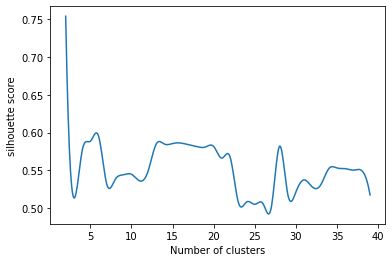

In [87]:
plot_scores(scores, number_clusters=40)

In [89]:
preds = kmeans(df_clean_num_stand, 14)

In [94]:
#Transform the data
pca = PCA(2)
df = pca.fit_transform(df_clean_num_stand)
 
df.shape

(1045, 2)

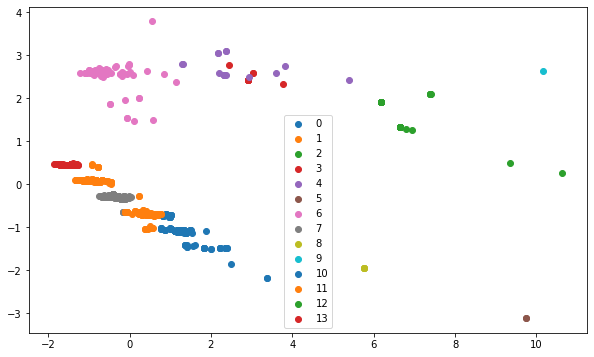

In [95]:
#Getting unique labels
 
u_labels = np.unique(preds)
 
#plotting the results:
plt.figure(figsize=(10, 6))
for i in u_labels:
  filtered_label = df[preds == i]
  plt.scatter(filtered_label[:,0] , filtered_label[:,1], label=i  )
plt.legend()
plt.show()

**df_clean_description** 
* DESCRIPTION


In [96]:
#Transform the data
pca = PCA(2)
df_desc = pca.fit_transform(tf_idf_matrix)
 
df_desc.shape

(1045, 2)

In [112]:
scores, nb_clusters = best_k(tf_idf_matrix)

For n_clusters = 20, silhouette score is 0.08401274638946692)
For n_clusters = 21, silhouette score is 0.08077310271541452)
For n_clusters = 22, silhouette score is 0.0894300513557551)
For n_clusters = 23, silhouette score is 0.09463995463978538)
For n_clusters = 24, silhouette score is 0.10082434079164025)
For n_clusters = 25, silhouette score is 0.10574288079018751)
For n_clusters = 26, silhouette score is 0.1112451247479592)
For n_clusters = 27, silhouette score is 0.11585952234729663)
For n_clusters = 28, silhouette score is 0.1205135153196995)
For n_clusters = 29, silhouette score is 0.12366354094476327)
For n_clusters = 30, silhouette score is 0.1270964940161266)
For n_clusters = 31, silhouette score is 0.12263242649536432)
For n_clusters = 32, silhouette score is 0.08216627032475995)
For n_clusters = 33, silhouette score is 0.08567664823920314)
For n_clusters = 34, silhouette score is 0.1362577856983079)
For n_clusters = 35, silhouette score is 0.13383270328064092)
For n_cluster

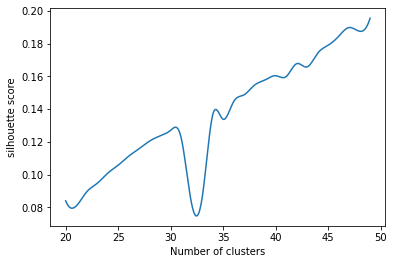

In [113]:
plot_scores(scores, number_clusters=50)

In [114]:
preds_desc = kmeans(df_clean_num_stand, 49)

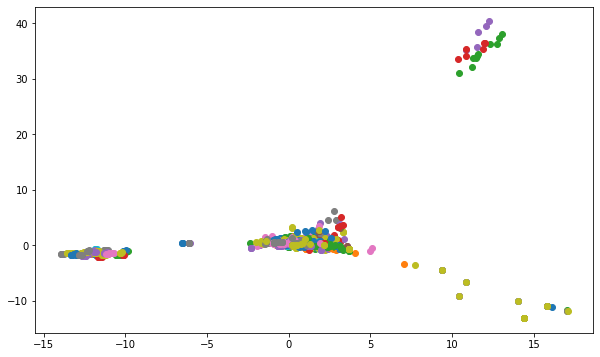

In [116]:
#Getting unique labels
 
u_labels = np.unique(preds_desc)
 
#plotting the results:
plt.figure(figsize=(10, 6))
for i in u_labels:
  filtered_label = df_desc[preds_desc == i]
  plt.scatter(filtered_label[:,0] , filtered_label[:,1], label=i  )
#plt.legend()
plt.show()

#Améliorations

* Combiner les descriptions et les colonnes numériques.
* Représenter les descriptions avec des embeddings. 
* Remplacer les données manquantes en utilisant (Amelia, knn,...) 